<a href="https://colab.research.google.com/github/SanchezJoseAntonio/Prediction_risk_diabetes/blob/main/Prediction_risk_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor

In [ ]:
file_path = "diabetes.csv"
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  file_path)

/tmp/ipython-input-1208700076.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.shape

(768, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Some of this data is biologically impossible. There is a minimum of 0 for SkinThickness, bloodpressure... This means that at least one observation has these values. These are clearly incorrect.


In [ ]:
df.duplicated().sum()

np.int64(0)

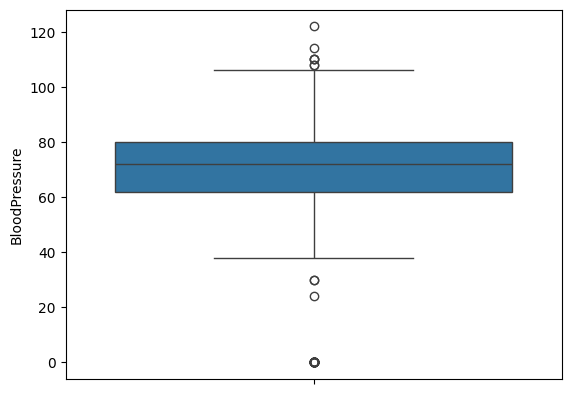

In [ ]:
sns.boxplot(df["BloodPressure"]);

In [ ]:
df[df["BloodPressure"] < 40].head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
18,1,103,30,38,83,43.3,0.183,33,0
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0


It's clear that there are missing values, that are just represented as 0. I'll now change them to NA for easier retrieval. I will update the columns that have 0 as a minimum and are continuous.

In [ ]:
cols = ["Glucose",	"BloodPressure",	"SkinThickness",	"Insulin",	"BMI"]
df[cols]=df[cols].replace(0, np.nan)

In [ ]:
df.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


The amount of missing values for skin thickness and insulin are very high. However, insulin is highly related to diabetes, and skin thickness is highly related to obesity, a major factor in diabetes. Therefore, I will not drop these features.


On the other hand, missingness can be informative (e.g they may or may not have done the test for a reason). This is why for insulin and skin thickness I will add a column regarding whether the value was missing or not. This will assure that this information can be evaluated by the algorithm later on, even after handling the missing values.

In [ ]:
df["Insulin_NA"]=df['Insulin'].isna().astype('category')
df["SkinThickness_NA"]=df['SkinThickness'].isna().astype('category')
df["Missing_Total"]=df.isna().sum(axis=1)
df["Missing_Total"].sort_values(ascending=False)

,Missing_Total
60,4
706,4
49,4
426,4
81,4
...,...
8,0
13,0
14,0
736,0


In [ ]:
df.drop(df.index[df["Missing_Total"]>3],axis=0, inplace=True) #Delete rows where there are more than 3 missing values.
df.drop("Missing_Total",axis=1,inplace=True)
df.shape

(761, 11)

In [ ]:
df2 = df.copy()

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_NA,SkinThickness_NA
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,True,False
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,True,False
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,True,True
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,False,False


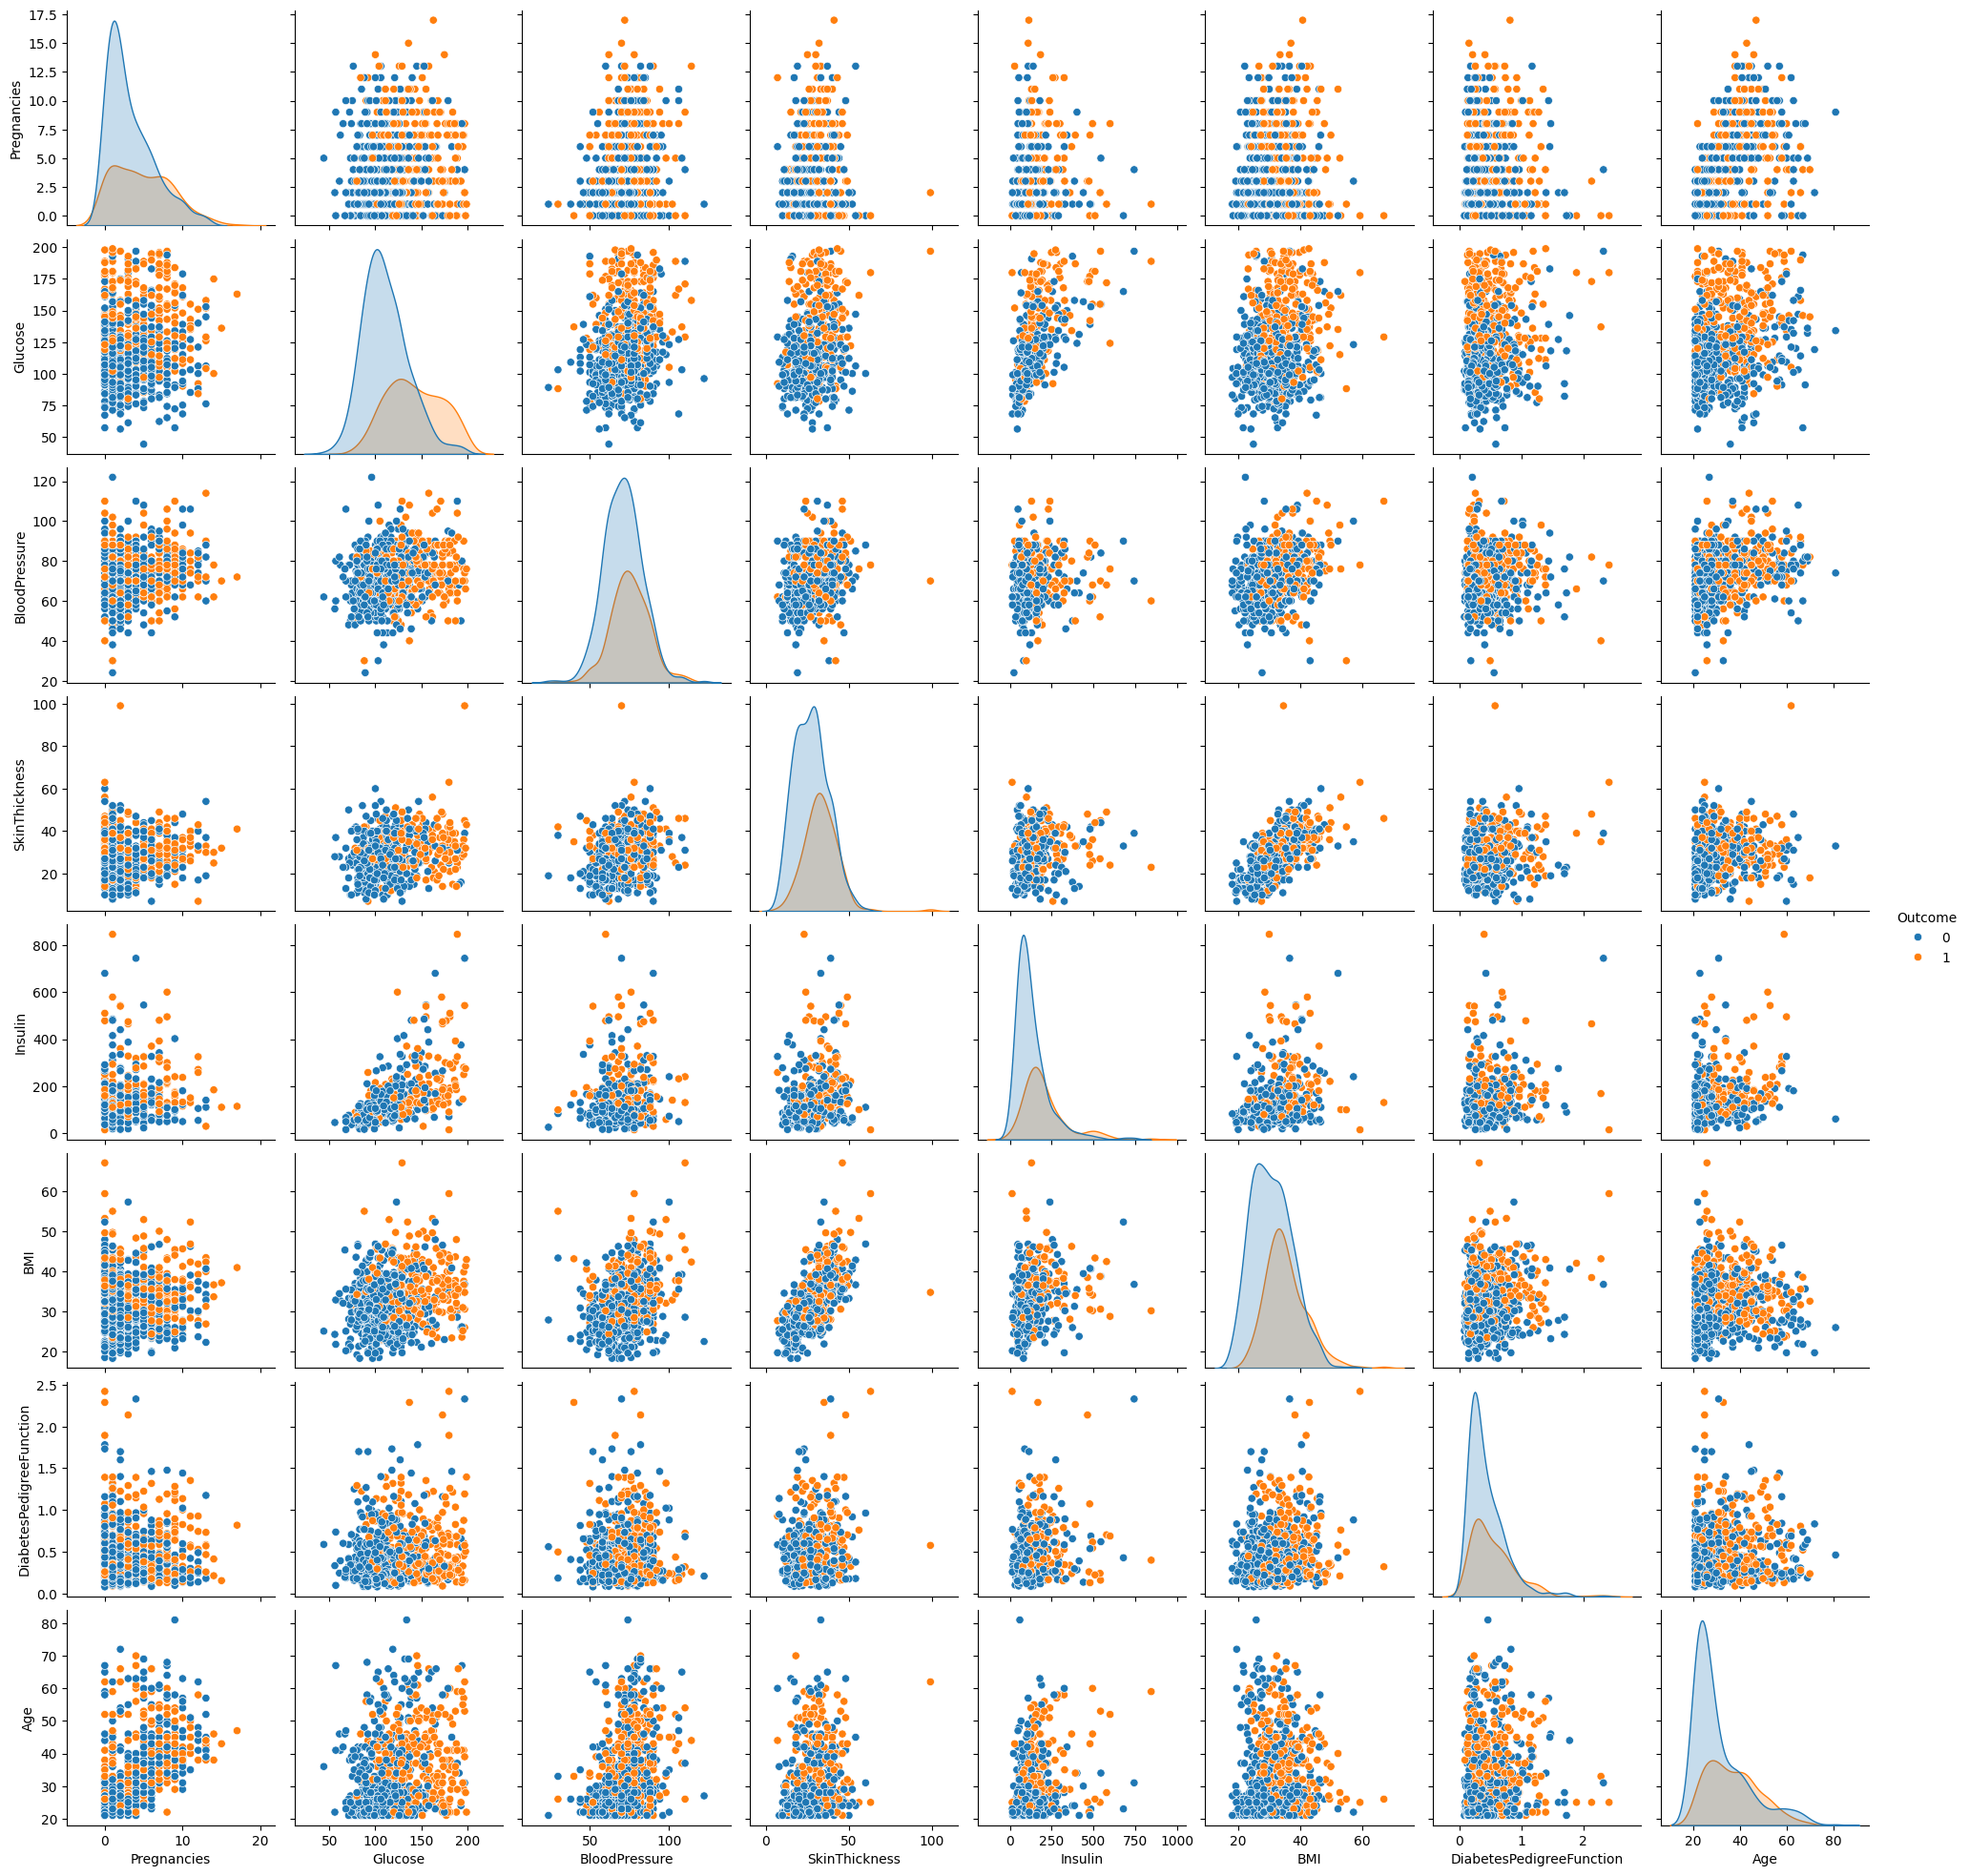

In [ ]:
sns.pairplot(df, hue="Outcome");

# Handling missing data: replacing by median
I will substitute the missing values by the median in each case. I will first divide the dataset in training and test data so there is no data leakage.

In [ ]:
X = df.drop(labels="Outcome",axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, stratify=y)


cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in cols:
  X_train[col]=X_train[col].replace(np.nan, X_train[col].median())
  X_test[col]=X_test[col].replace(np.nan, X_train[col].median()) # Imputing for the test with the training data

In [ ]:
X_test.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Insulin_NA,0
SkinThickness_NA,0


# Checking feature importance
I will evaluate feature importance through a random forest. This can help me figure out if any features are irrelevant and simplify the model. Because impurity importance can bias the results, I will use permutation importance.

In [ ]:
def imp_rf(X_train, X_test, y_train, y_test, random_state=25, n_estimators=200, class_weight = "balanced"):
  rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight=class_weight)
  model =rf.fit(X_train, y_train)
  result = permutation_importance(model, X_train, y_train, n_repeats=10,random_state=random_state)
  return result


In [ ]:
ranking = pd.DataFrame(zip(df.drop(columns=['Outcome']).columns, imp_rf(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test).importances_mean))
ranking.sort_values(by=1, axis=0)

,0,1
9,SkinThickness_NA,0.000000
8,Insulin_NA,0.000000
3,SkinThickness,0.008596
2,BloodPressure,0.018772
0,Pregnancies,0.019474
4,Insulin,0.046140
6,DiabetesPedigreeFunction,0.061754
7,Age,0.087719
5,BMI,0.107018
1,Glucose,0.194211


Surprisingly, the columns that represent missing values for skin thickness and insulin have a permutation importance of 0 or almost 0. This is because during the pre-processing, I substituted the NA values for the median. The trees are adjusting by using the information from the median in the insulin column instead of from the missing values column.



# Handling missing data with lightgbm
I will now proceed to use lightgbm to handle the missing data. It will infer the data that should be in the missing values.
To avoid data leakage, I will separate the test and training data, and apply the model to both of them.

In [ ]:
df2["NA_Total"]=df2.isna().sum(axis=1)
df2.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,28
SkinThickness,220
Insulin,367
BMI,4
DiabetesPedigreeFunction,0
Age,0
Outcome,0
Insulin_NA,0


From the previous data, I know glucose and BMI have specially high importances so the imputation of these two variables is of special relevance. I can also see that the missing values from  them are 5 and 4 rows respectively. Let's examine them closely

In [ ]:
df2[df2["BMI"].isna()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_NA,SkinThickness_NA,NA_Total
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1,True,True,3
145,0,102.0,75.0,23.0,NaN,NaN,0.572,21,0,True,False,2
371,0,118.0,64.0,23.0,89.0,NaN,1.731,21,0,False,False,1
684,5,136.0,82.0,NaN,NaN,NaN,0.640,69,0,True,True,3


In [ ]:
df2[df2["Glucose"].isna()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_NA,SkinThickness_NA,NA_Total
75,1,NaN,48.0,20.0,NaN,24.7,0.140,22,0,True,False,2
182,1,NaN,74.0,20.0,23.0,27.7,0.299,21,0,False,False,1
342,1,NaN,68.0,35.0,NaN,32.0,0.389,22,0,True,False,2
349,5,NaN,80.0,32.0,NaN,41.0,0.346,37,1,True,False,2
502,6,NaN,68.0,41.0,NaN,39.0,0.727,41,1,True,False,2


I see two observations in BMI that contain 3 missing values. I will drop these as they can introduce noise in the model.

In [ ]:
df2.drop([9,684], axis=0, inplace=True)
df2.drop("NA_Total", axis=1, inplace=True)
df2[df2["BMI"].isna()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_NA,SkinThickness_NA
145,0,102.0,75.0,23.0,NaN,NaN,0.572,21,0,True,False
371,0,118.0,64.0,23.0,89.0,NaN,1.731,21,0,False,False


I will start imputing the rest of the missing values.Therefore I will divide the data in training and test data

In [ ]:
X = df2.drop(labels="Outcome",axis=1)
y = df2["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=33, stratify=y)

In [ ]:
# I will take out InsulinNA and SkinthicknessNA. Instead they will be generated later with all the missing columns.
X_train.drop(["Insulin_NA","SkinThickness_NA"], inplace= True, axis = 1)
X_test.drop(["Insulin_NA","SkinThickness_NA"], inplace= True, axis = 1)
na_cols = X_train.isna().sum()
# Sorting the values from the least amount of NAs to the most, so the ones with the most can use more information
# The ones with 0 NAs should be done last, in case there are NAs in the test data, they can be filled with the most information possible
na_train = na_cols.sort_values().sort_values(key=lambda x: x.eq(0), kind='mergesort')
na_train

,0
Glucose,2
BMI,2
BloodPressure,22
SkinThickness,176
Insulin,287
Pregnancies,0
Age,0
DiabetesPedigreeFunction,0


In [ ]:
na_test  = X_test.isna().sum()
na_test

,0
Pregnancies,0
Glucose,3
BloodPressure,6
SkinThickness,42
Insulin,78
BMI,0
DiabetesPedigreeFunction,0
Age,0


In [ ]:
for col in X_train.columns:
  X_train[col+"_is_nan"] = X_train[col].isna().astype("category")
  X_test[col+"_is_nan"] = X_test[col].isna().astype("category")

X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies_is_nan,Glucose_is_nan,BloodPressure_is_nan,SkinThickness_is_nan,Insulin_is_nan,BMI_is_nan,DiabetesPedigreeFunction_is_nan,Age_is_nan
492,4,99.0,68.0,38.0,NaN,32.8,0.145,33,False,False,False,False,True,False,False,False
666,4,145.0,82.0,18.0,NaN,32.5,0.235,70,False,False,False,False,True,False,False,False
587,6,103.0,66.0,NaN,NaN,24.3,0.249,29,False,False,False,True,True,False,False,False
669,9,154.0,78.0,30.0,100.0,30.9,0.164,45,False,False,False,False,False,False,False,False
361,5,158.0,70.0,NaN,NaN,29.8,0.207,63,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,2,129.0,74.0,26.0,205.0,33.2,0.591,25,False,False,False,False,False,False,False,False
339,7,178.0,84.0,NaN,NaN,39.9,0.331,41,False,False,False,True,True,False,False,False
369,1,133.0,102.0,28.0,140.0,32.8,0.234,45,False,False,False,False,False,False,False,False
615,3,106.0,72.0,NaN,NaN,25.8,0.207,27,False,False,False,True,True,False,False,False


In [ ]:
num = 0
while True:
  # Stop when all columns have been evaluated
  if num == len(na_train.index):
    break
  col = na_train.index[num]
  num += 1
  # When no missing values in test or training data, do not evaluate the column
  if na_train[col]==0 or na_test[col]==0:
    continue
  else:
    x_train_na = X_train.drop(col, axis = 1)
    y_train_na = X_train[col]
    # If there are missing values in training data, separate it into test training and train training data.
    if na_train[col]!=0:
      x_test_train_na = x_train_na.loc[x_train_na[col+"_is_nan"]==True]
      y_test_train_na = y_train_na.loc[y_train_na.isna()]
      x_train_na = x_train_na.loc[x_train_na[col+"_is_nan"]==False]
      y_train_na = y_train_na.dropna()
    # If there are missing values in test data, separate it into target (y) and predictors (x)
    if na_test[col]!=0:
      x_test_test_na = X_test.loc[X_test[col].isna()].drop([col], axis = 1)
      y_test_test_na = X_test.loc[X_test[col].isna()]
    # Train the model with the training data
    lgbm = LGBMRegressor(verbosity=-1)
    lgbm.fit(x_train_na, y_train_na)

    y_pred_train= lgbm.predict(x_test_train_na)
    y_pred_test= lgbm.predict(x_test_test_na)

    # Fill in the NA values with the predicted ones
    X_train.loc[x_test_train_na.index,col]=y_pred_train
    X_test.loc[x_test_test_na.index,col]=y_pred_test

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 567, number of used features: 10
[LightGBM] [Info] Start training from score 121.795414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies_is_nan,Glucose_is_nan,BloodPressure_is_nan,SkinThickness_is_nan,Insulin_is_nan,BMI_is_nan,DiabetesPedigreeFunction_is_nan,Age_is_nan
609,1,111.0,62.000000,13.000000,182.000000,24.0,0.138,23,False,False,False,False,False,False,False,False
627,0,132.0,78.000000,27.766277,177.503049,32.4,0.393,21,False,False,False,True,True,False,False,False
392,1,131.0,64.000000,14.000000,415.000000,23.7,0.389,21,False,False,False,False,False,False,False,False
732,2,174.0,88.000000,37.000000,120.000000,44.5,0.646,24,False,False,False,False,False,False,False,False
435,0,141.0,78.839953,45.604783,258.543331,42.4,0.205,29,False,False,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0,139.0,62.000000,17.000000,210.000000,22.1,0.207,21,False,False,False,False,False,False,False,False
134,2,96.0,68.000000,13.000000,49.000000,21.1,0.647,26,False,False,False,False,False,False,False,False
285,7,136.0,74.000000,26.000000,135.000000,26.0,0.647,51,False,False,False,False,False,False,False,False
618,9,112.0,82.000000,24.000000,194.599283,28.2,1.282,50,False,False,False,False,True,False,False,False


In [ ]:
ranking = pd.DataFrame(zip(X_train.columns, imp_rf(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test).importances_mean))
ranking.sort_values(by=1, axis=0)

,0,1
13,BMI_is_nan,0.000000
11,SkinThickness_is_nan,0.000000
14,DiabetesPedigreeFunction_is_nan,0.000000
15,Age_is_nan,0.000000
9,Glucose_is_nan,0.000000
8,Pregnancies_is_nan,0.000000
12,Insulin_is_nan,0.001054
10,BloodPressure_is_nan,0.001757
2,BloodPressure,0.013181
0,Pregnancies,0.024605


In [ ]:
X_train.drop(["BMI_is_nan","SkinThickness_is_nan","DiabetesPedigreeFunction_is_nan",
              "Age_is_nan", "Glucose_is_nan", "Pregnancies_is_nan"], axis=1, inplace=True) #I will delete all the features that are not adding anything to the model to make it more simple

Accuracy: 0.737


# Cross-validated hyper-parameter tuning